## Full optimizer comparison
Notebook written by Lanyue Zhang and Alan Kaptanoglu

This post-processing file takes the results from Pareto-optimal scans of the dysts database with different optimizers and varying amounts of noise, as in the example Jupyter notebook 16_benchmark_paper.ipynb. The primary goal of this notebook is to fully reproduce the results shown in our new system identification benchmark paper.

An interactive version of this notebook is available on binder
[![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/dynamicslab/pysindy/v1.7.3?filepath=examples/16_noise_robustness/optimizer_comparison.ipynb)

In [1]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
from scipy.integrate import odeint
from sklearn.metrics import mean_squared_error
from dysts.base import make_trajectory_ensemble
from dysts.base import get_attractor_list
import dysts.flows as flows
import dysts.datasets as datasets
from dysts.equation_utils import *
import time
import pysindy as ps

path = 'data/'

In [2]:
# Import list of the dynamical properties, sorted alphabetically by the system names
medl_list = np.loadtxt('description_lengths')
lyap_list = np.loadtxt('lyapunov_exponents')
nonlinear_sum = np.loadtxt('nonlinearity_metric')
scale_list_avg = np.loadtxt('scale_separation_metric')
systems_list_cleaned = np.loadtxt('systems_list_cleaned', dtype=str)
num_attractors = len(medl_list)

### Import normalized X_dot RMSE errors and normalized model coefficient errors
This is done for the STLSQ, SR3 (nu = 1 and nu = 0.1), Lasso, and MIOSR optimizers AND the STLSQ optimizer using the weak form!

In [3]:
error_metrics = ['avg', 'std']
error_types = ['coef', 'rmse']
optimizers = ['STLSQ', 'SR3', 'SR3_nu01', 'Lasso', 'MIOSR']
noise_levels = ['noise0.00', 'noise0.10', 'noise1.00']
weak_forms = ['False', 'True']
errors = []
i = 0
for weak_form in weak_forms:
    for optimizer in optimizers:
        for noise_level in noise_levels:
            file_path = path + 'errors_' + optimizer + '_' + noise_level + '_weakform' + weak_form
            if weak_form == 'True':
                if optimizer != 'MIOSR':
                    (avg_rmse_error, std_rmse_error, 
                     avg_coef_error, std_coef_error, 
                     avg_rmse_error_strong, std_rmse_error_strong) = np.loadtxt(
                        file_path, unpack=True
                    )
                    errors.append(avg_coef_error)
                    errors.append(std_coef_error)
                    errors.append(avg_rmse_error_strong)
                    errors.append(std_rmse_error_strong)
                    i += 4
            else:
                avg_rmse_error, std_rmse_error, avg_coef_error, std_coef_error = np.loadtxt(
                    file_path, unpack=True
                )
                errors.append(avg_coef_error)
                errors.append(std_coef_error)
                errors.append(avg_rmse_error)
                errors.append(std_rmse_error)
                i += 4

### Plot all the errors for all the optimizers and all the systems, on a single figure!
First plot will be all the results when the data is clean -- no added noise.

(0.0002, 15)

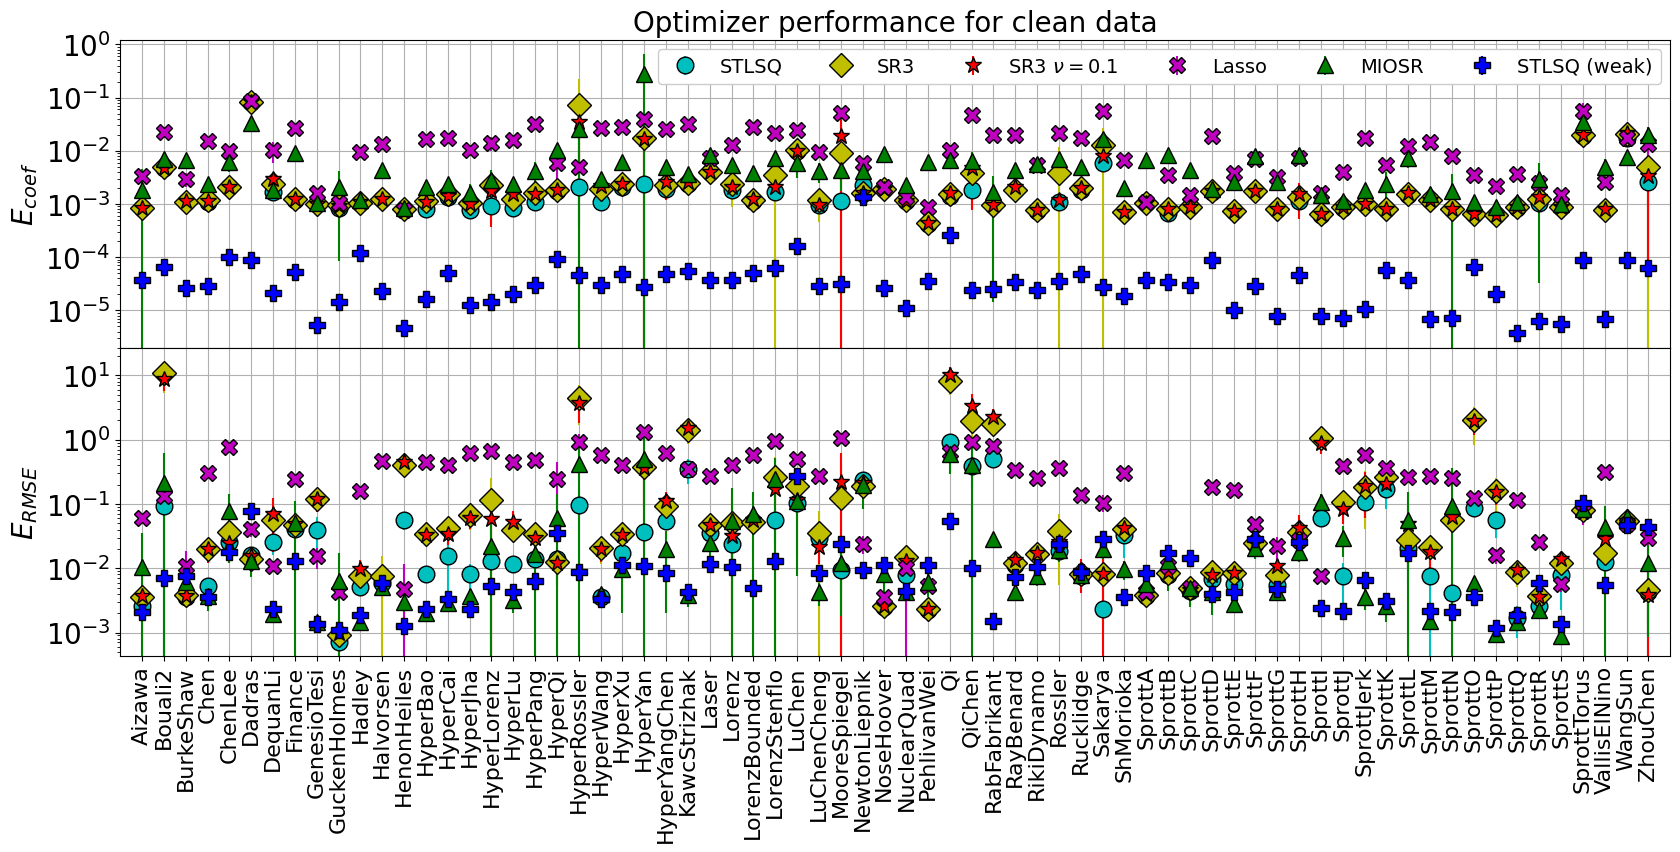

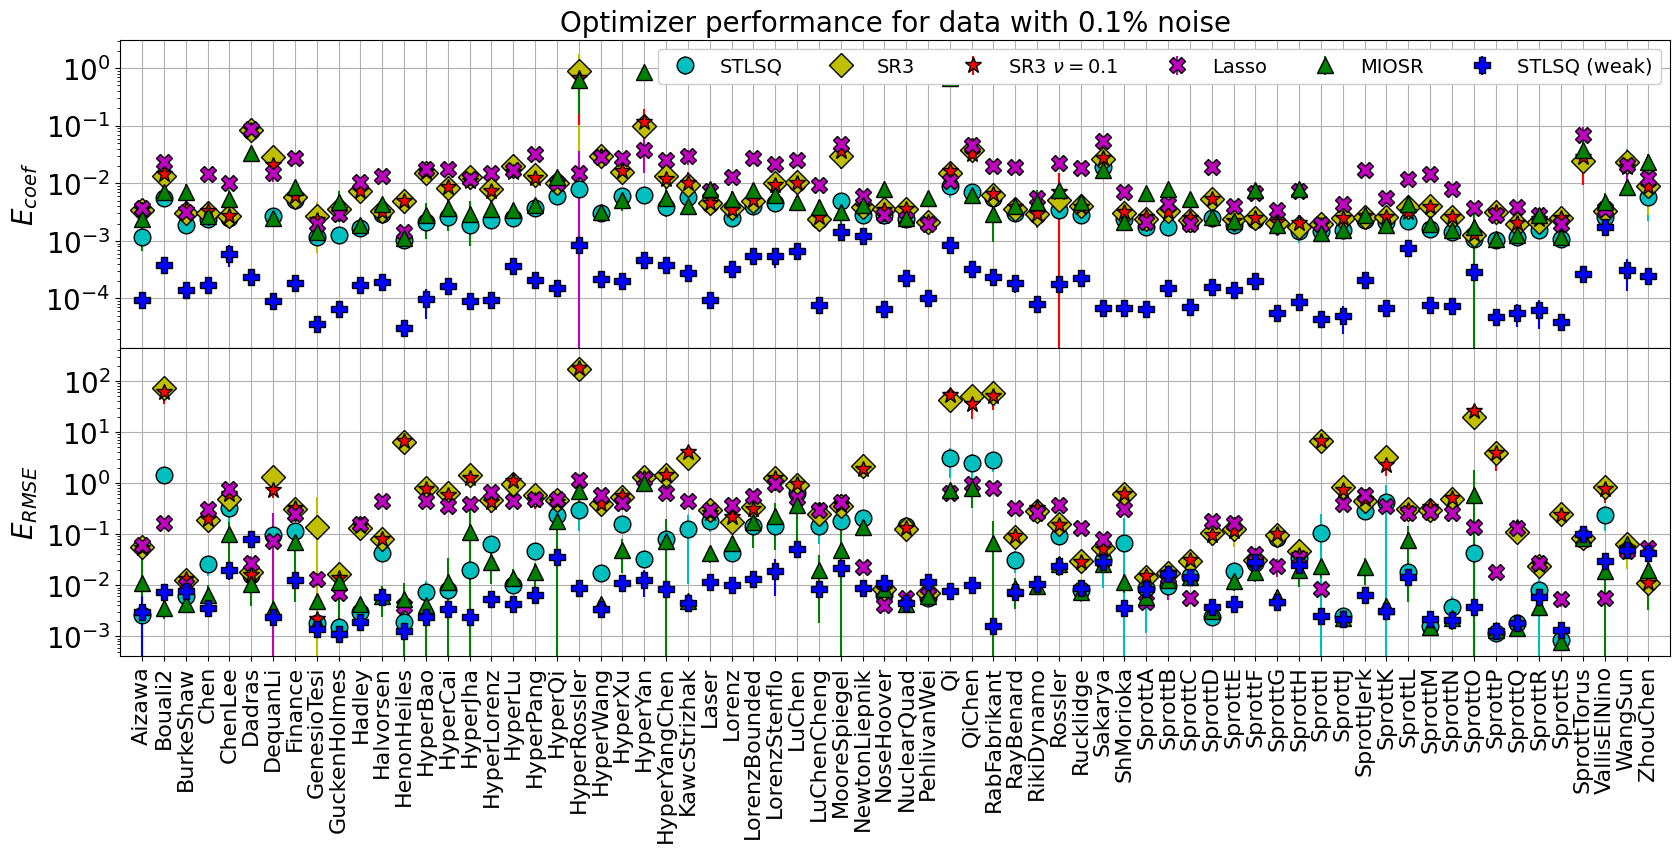

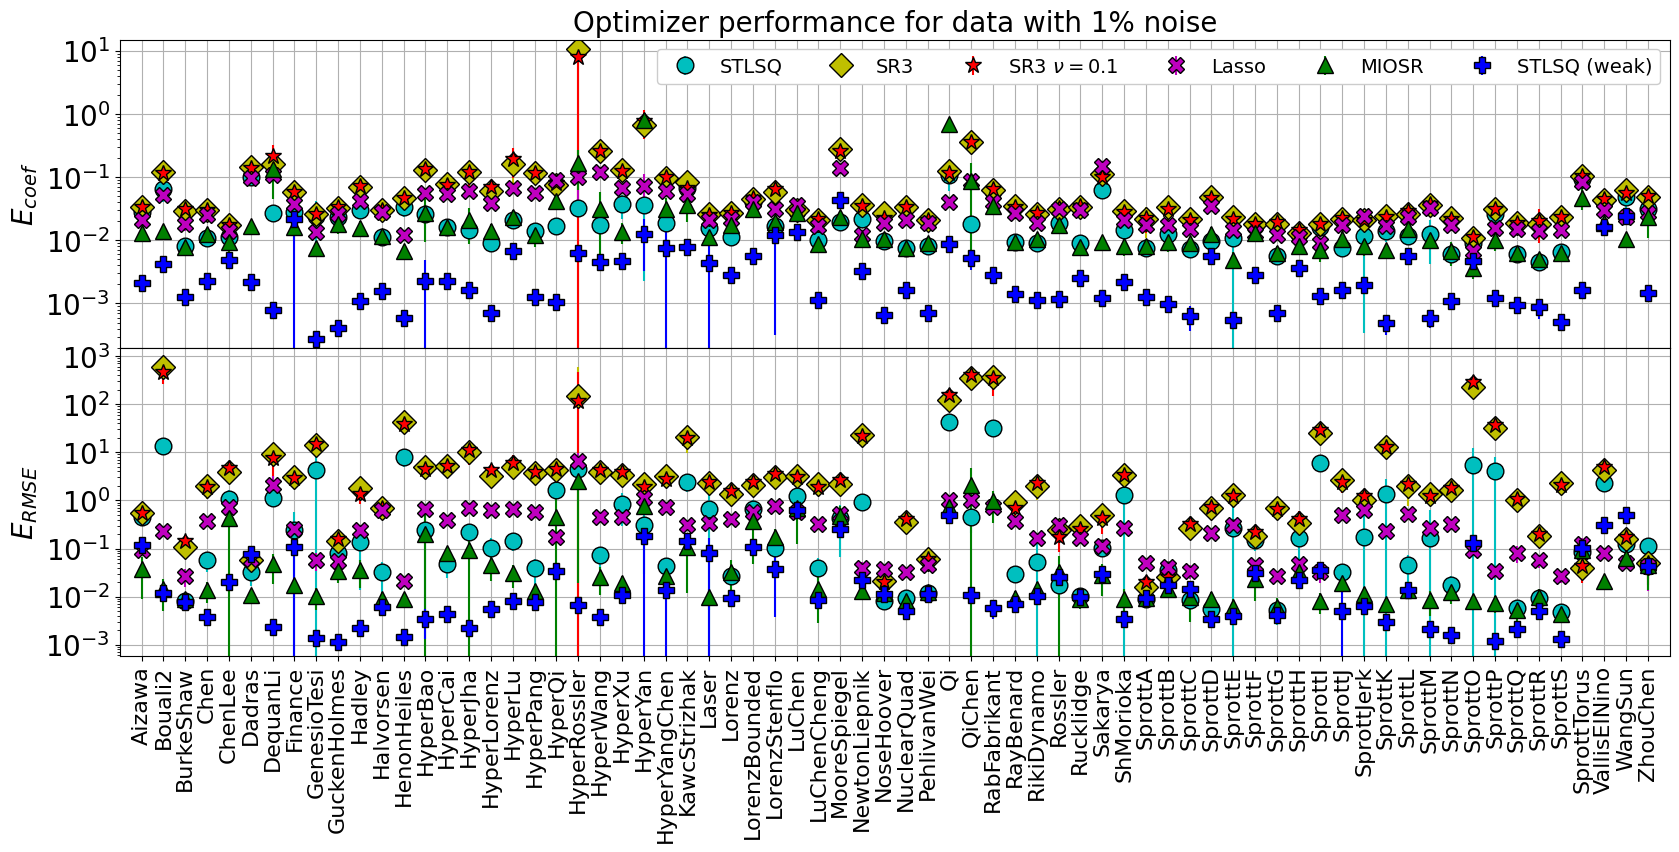

In [4]:
import matplotlib.gridspec as gridspec
ms = 10
fmts = ['co', 'yD', 'r*', 'mX', 'g^', 'bP', 'yv', 'r>', 'm<', 'gd']
labels = ["STLSQ", "SR3", r"SR3 $\nu = 0.1$", "Lasso", "MIOSR", 
          "STLSQ (weak)", "SR3 (weak)", r"SR3 $\nu = 0.1$ (weak)", "Lasso (weak)"]
title_append = ['for clean data', 'for data with 0.1% noise', 'for data with 1% noise']
for j in range(3):
    plt.figure(j + 1, figsize=(20, 8))
    gs = gridspec.GridSpec(2, 1, hspace=0, wspace=0)
    plt.subplot(gs[0])
    q = 0
    for i in range(4 * j, 72, 12):
        plt.errorbar(
            np.arange(num_attractors),
            errors[i],
            errors[i + 1],
            fmt=fmts[q],
            label=labels[q],
            markersize=ms + 2,
            markeredgecolor='k'
        )
        q = q + 1
    plt.grid(True)
    plt.yscale("log")
    ax = plt.gca()
    plt.xticks(np.arange(num_attractors), rotation="vertical", fontsize=16)
    plt.xlim(-1, num_attractors)
    ax.set_xticklabels([])
    plt.yticks(fontsize=20)
    plt.ylabel(r"$E_{coef}$", fontsize=20)
    plt.title('Optimizer performance ' + title_append[j], fontsize=20)
    plt.legend(
        framealpha=1.0,
        ncol=12,
        fontsize=14,
    )
    plt.subplot(gs[1])
    q = 0
    for i in range(4 * j + 2, 72, 12):
        plt.errorbar(
            np.arange(num_attractors),
            errors[i],
            errors[i + 1],
            fmt=fmts[q],
            label=labels[q],
            markersize=ms + 2,
            markeredgecolor='k'
        )
        q = q + 1
    plt.grid(True)
    plt.yscale("log")
    plt.ylabel(r"$E_{RMSE}$", fontsize=20)
    ax = plt.gca()
    plt.xticks(np.arange(num_attractors), rotation="vertical", fontsize=16)
    plt.xlim(-1, num_attractors)
    ax.set_xticklabels(np.array(systems_list_cleaned))
    plt.yticks(fontsize=20)
    
plt.figure(3)
plt.subplot(gs[0])
plt.ylim(2e-4, 15)

### Summarize the mean and median errors, now computed across all the dynamical systems
This gives an overall error performance for each optimizer, for each noise level, which can be plotted against the computational time used by the optimization algorithm.

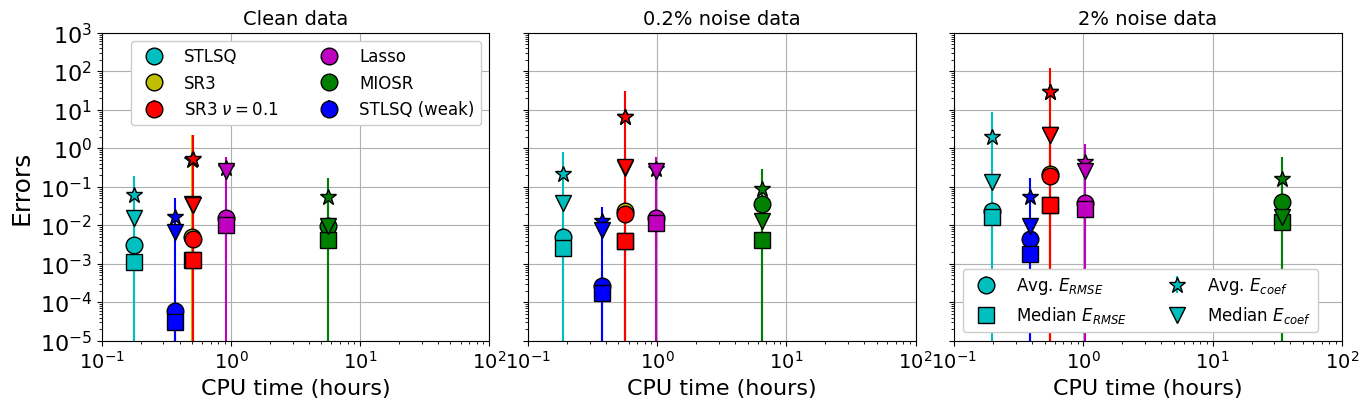

In [6]:
# Run times in hours for each of the optimizers, at each of noise levels of 0, 0.2, 2%
run_times = np.array(
    [641, 1812, 1820, 3321, 20194, 1317,
     676, 2027, 2035, 3535, 23175, 1353,
     706, 1990, 1993, 3687, 124694, 1381,
    ]
) / 3600
ms = 12

plt.figure(figsize=(16, 4))
gs = gridspec.GridSpec(1, 3, hspace=0, wspace=0.1)
fmts = ['c', 'y', 'r', 'm', 'g', 'b']

def make_error_plots(start_index=0):
    if start_index == 0:
        fmt1 = 'o'
        fmt2 = 's'
    else:
        fmt1 = '*'
        fmt2 = 'v'
    q = 0
    plt.subplot(gs[0])
    for i in range(start_index, 72, 12):
        error = errors[i]
        if start_index > 0:
            label = ''
        else:
            label = labels[q]
        plt.errorbar(
            run_times[q], 
            np.mean(error), 
            np.std(error), 
            fmt=fmts[q] + fmt1, 
            label=label, 
            markersize=ms, 
            markeredgecolor='k'
        )
        plt.errorbar(
            run_times[q], 
            np.median(error), 
            fmt=fmts[q] + fmt2, 
            markersize=ms, 
            markeredgecolor='k'
        )
        q = q + 1

    q = 0
    plt.subplot(gs[1])
    for i in range(start_index + 4, 72, 12):
        error = errors[i]
        plt.errorbar(
            run_times[q + 6], 
            np.mean(error), 
            np.std(error), 
            fmt=fmts[q] + fmt1, 
            label=labels[q], 
            markersize=ms, 
            markeredgecolor='k'
        )
        plt.errorbar(
            run_times[q + 6], 
            np.median(error), 
            fmt=fmts[q] + fmt2, 
            label=labels[q], 
            markersize=ms, 
            markeredgecolor='k'
        )
        q = q + 1

    q = 0
    plt.subplot(gs[2])
    for i in range(8 + start_index, 72, 12):
        error = errors[i]
        if i < 10:
            label = r'Avg. $E_{RMSE}$'
        elif i < 12:
            label = r'Avg. $E_{coef}$'
        else:
            label = ''
        plt.errorbar(
            run_times[q + 12], 
            np.mean(error), 
            np.std(error), 
            fmt=fmts[q] + fmt1, 
            label=label,
            markersize=ms, 
            markeredgecolor='k'
        )
        if i < 10:
            label = r'Median $E_{RMSE}$'
        elif i < 12:
            label = r'Median $E_{coef}$'
        else:
            label = ''
        plt.errorbar(
            run_times[q + 12], 
            np.median(error), 
            label=label,
            fmt=fmts[q] + fmt2, 
            markersize=ms, 
            markeredgecolor='k'
        )
        q = q + 1
        
make_error_plots(0)
make_error_plots(2)
    
noise_levels = ['Clean', '0.2% noise', '2% noise']
for i in range(3):
    plt.subplot(gs[i])
    plt.grid(True)
    plt.ylim(1e-5, 1e3)
    plt.yscale('log')
    plt.xscale('log')
    plt.xlim(0.1, 100)
    plt.title(noise_levels[i] + ' data', fontsize=14)
    if i == 0:
        plt.legend(framealpha=1.0, fontsize=12, ncol=2, loc='best')
    if i == 2:
        plt.legend(
#             [r'Avg. $E_{RMSE}$', r'Avg. $E_{coef}$'], 
            framealpha=1.0, fontsize=12, ncol=2, loc='best'
        )
    plt.xlabel("CPU time (hours)", fontsize=16)
    plt.yticks(fontsize=16)
    plt.xticks(fontsize=14)
    if i > 0:
        ax = plt.gca()
        ax.set_yticklabels([])
    else:
        plt.ylabel("Errors", fontsize=18)
    
plt.savefig('optimizer_error_summary.pdf', bbox_inches="tight")
plt.show()

# Does symbolic regression depend on dynamical properties?
Dynamical properties of interest include:
1. Level of chaos, as measured by the largest Lyapunov exponent,
2. Scale separation, as measured by the ratio of the "dominant" timescale to the "minimum significant" time scale (see William Gilpin's dysts paper),
3. Syntactical complexity, as measured by the description length metric,
4. Degree of nonlinearity, measured as the highest polynomially nonlinearity appearing in the governing equations. 

### Take errors from one of the optimizer results, and plot how the performance depends on the dynamical properties
We try simple linear, log-linear, and log-log plots with each property, and plot the best fit.

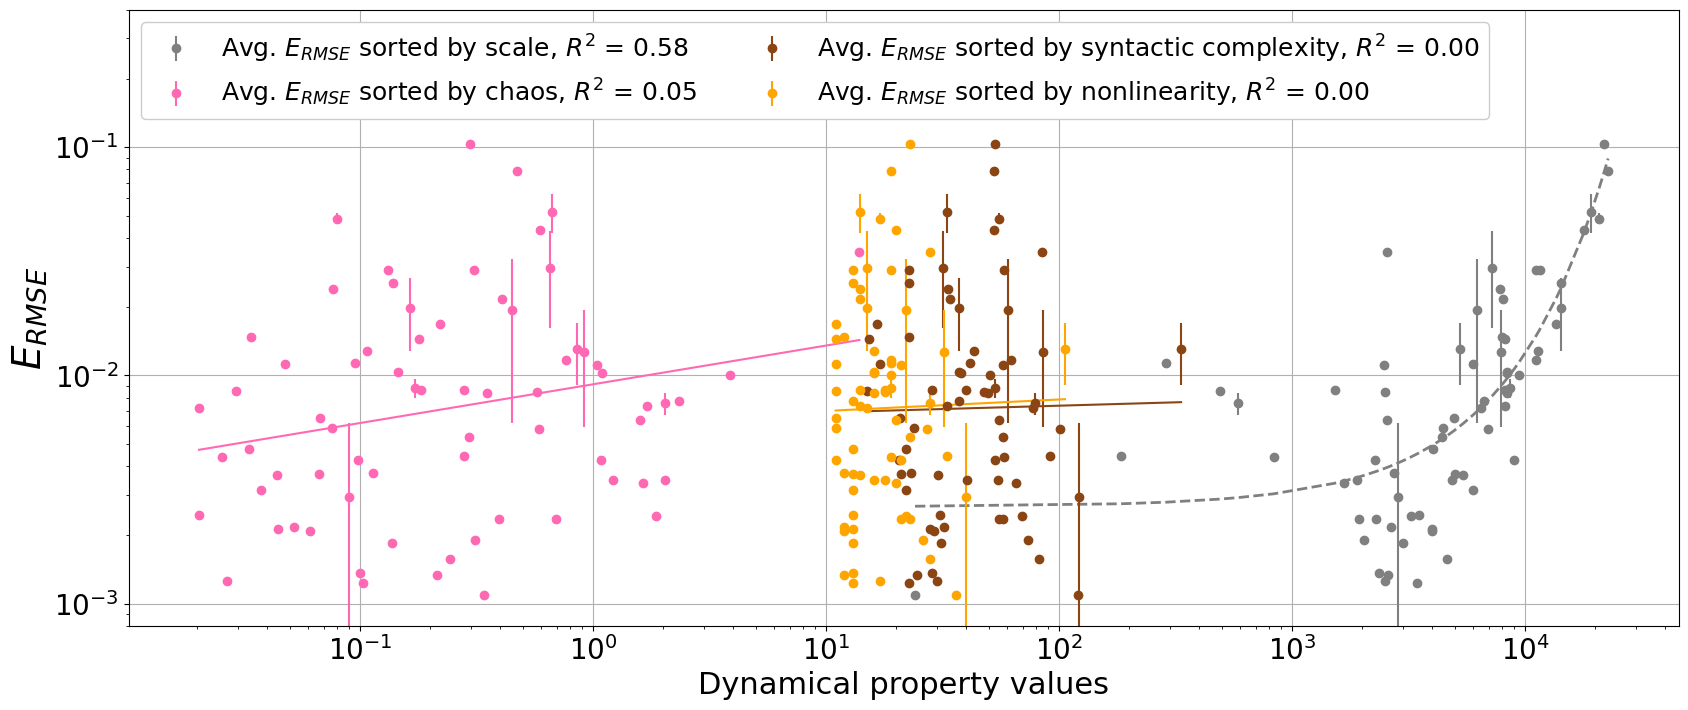

In [7]:
from scipy.stats import linregress

# get the errors from the MIOSR optimizer results
cerrs = errors[64]
avg_rmse_error = errors[66]
std_rmse_error = errors[67]
plt.figure(figsize=(20, 8))

# reorder things by the amount of scale separation and then plot performance + fits
def make_fit(list_avg, property_type='scale'):
    scale_sort = np.argsort(list_avg)
    scale_list_sorted = np.sort(list_avg)
    slope, intercept, r_value, p_value, std_err = linregress(
        scale_list_sorted, avg_rmse_error[scale_sort]
    )
    slope1, intercept1, r_value1, p_value1, std_err1 = linregress(
        scale_list_sorted, np.log(avg_rmse_error[scale_sort])
    )
    slope2, intercept2, r_value2, p_value2, std_err2 = linregress(
        np.log(scale_list_sorted), np.log(avg_rmse_error[scale_sort])
    )
    slope_coef, intercept_coef, r_value_coef, p_value_coef, std_err_coef = linregress(
        scale_list_sorted, cerrs[scale_sort]
    )
    
    if property_type == 'scale':
        color = 'grey'
    elif property_type == 'chaos':
        color = 'hotpink'
    elif property_type == 'syntactic complexity':
        color = 'saddlebrown'
    else:
        color = 'orange'
        
    if property_type == 'scale':
        color = 'grey'
        plt.plot(scale_list_sorted, np.exp(slope1 * scale_list_sorted + intercept1), 
                 color="grey", linestyle='--', linewidth=2)
        plt.errorbar(
            scale_list_sorted,
            avg_rmse_error[scale_sort],
            std_rmse_error[scale_sort],
            color=color,
            fmt="o",
            label="Avg. $E_{RMSE}$ sorted by " + property_type + ", $R^2$ = " + "{0:.2f}".format(r_value1**2)
        )
    else:
        plt.plot(scale_list_sorted, np.exp(intercept2) * scale_list_sorted ** slope2, color=color)
        plt.errorbar(
            scale_list_sorted,
            avg_rmse_error[scale_sort],
            std_rmse_error[scale_sort],
            color=color,
            fmt="o",
            label="Avg. $E_{RMSE}$ sorted by " + property_type + ", $R^2$ = " + "{0:.2f}".format(r_value2**2)
        )

make_fit(scale_list_avg)
make_fit(lyap_list, 'chaos')
make_fit(medl_list, 'syntactic complexity')
make_fit(nonlinear_sum, 'nonlinearity')

# polish the figure
plt.xscale("log")
plt.grid(True)
plt.yscale('log')
plt.legend(
    loc="upper left",
    framealpha=1.0,
    ncol=2,
    fontsize=18,
)
ax = plt.gca()
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlabel('Dynamical property values', fontsize=22)
plt.ylabel(r'$E_{RMSE}$', fontsize=28)
plt.ylim(0.8e-3, 0.4)
plt.show()

### Summarize the $R^2$ values for all the fits of all the optimizers, at each noise level
Rather than producing the rather complicated plot above over and over, here we record the $R^2$ coefficients of determination for each fit of (dynamical property, RMSE error), and plot the results.

In [8]:
scale_sort = np.argsort(scale_list_avg)
scale_list_sorted = np.sort(scale_list_avg)
chaos_sort = np.argsort(lyap_list)
chaos_list_sorted = np.sort(lyap_list)
syntax_sort = np.argsort(medl_list)
syntax_list_sorted = np.sort(medl_list)
nonlinear_sort = np.argsort(nonlinear_sum)
nonlinear_list_sorted = np.sort(nonlinear_sum)
    
def compute_r2s(errors, start_index=2):    
    r_values_scale = []
    r_values_chaos = []
    r_values_syntax = []
    r_values_nonlinear = []
    for i in range(start_index, 72, 4):
        avg_rmse_error = errors[i]
        std_rmse_error = errors[i + 1]
        slope1, intercept1, r_value1, p_value1, std_err1 = linregress(
            scale_list_sorted, np.log(avg_rmse_error[scale_sort])
        )
        r_values_scale.append(r_value1 ** 2)

        slope2, intercept2, r_value2, p_value2, std_err2 = linregress(
            np.log(chaos_list_sorted), np.log(avg_rmse_error[chaos_sort])
        )
        r_values_chaos.append(r_value2 ** 2)

        slope2, intercept2, r_value2, p_value2, std_err2 = linregress(
            np.log(syntax_list_sorted), np.log(avg_rmse_error[syntax_sort])
        )
        r_values_syntax.append(r_value2 ** 2)

        slope2, intercept2, r_value2, p_value2, std_err2 = linregress(
            np.log(nonlinear_list_sorted), np.log(avg_rmse_error[nonlinear_sort])
        )
        r_values_nonlinear.append(r_value2 ** 2)
    return r_values_scale, r_values_chaos, r_values_syntax, r_values_nonlinear

r_values_scale, r_values_chaos, r_values_syntax, r_values_nonlinear = compute_r2s(errors)

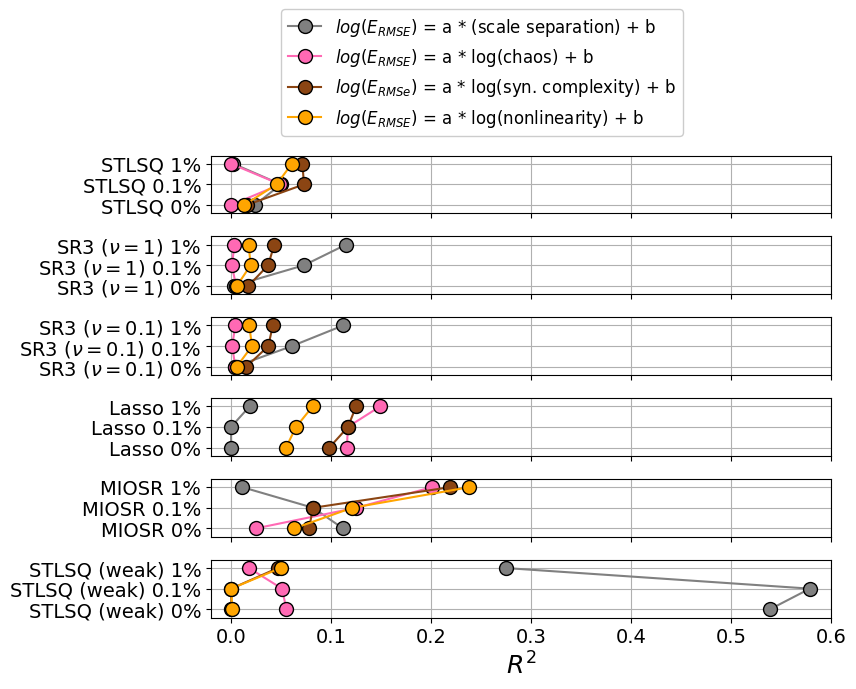

In [10]:
def plot_dynamical_properties(scale, chaos, syntax, nonlinear):
    ms = 10
    plt.figure(figsize=(8, 6))
    gs = gridspec.GridSpec(6, 1, hspace=0.4, wspace=0)
    opt_list = ['STLSQ', r'SR3 ($\nu = 1$)', r'SR3 ($\nu = 0.1$)', r'Lasso', r'MIOSR', 'STLSQ (weak)']
    for i in range(6):
        plt.subplot(gs[i])
        plt.plot(scale[i * 3: (i + 1) * 3], np.arange(3), 
                 color='grey', marker='o', markersize=ms, 
                 markeredgecolor='k', label=r'$log(E_{RMSE})$ = a * (scale separation) + b')
        plt.plot(chaos[i * 3: (i + 1) * 3], np.arange(3), 
                 color='hotpink', marker='o', markersize=ms, 
                 markeredgecolor='k',label=r'$log(E_{RMSE})$ = a * log(chaos) + b')
        plt.plot(syntax[i * 3: (i + 1) * 3], np.arange(3), 
                 color='saddlebrown', marker='o', markersize=ms, 
                 markeredgecolor='k',label=r'$log(E_{RMSe})$ = a * log(syn. complexity) + b')
        plt.plot(nonlinear[i * 3: (i + 1) * 3], np.arange(3), 
                 color='orange', marker='o', markersize=ms, 
                 markeredgecolor='k',label=r'$log(E_{RMSE})$ = a * log(nonlinearity) + b')
        plt.grid(True)
        plt.yticks(np.arange(3), fontsize=14)
        ax = plt.gca()
        plt.xlim(-0.02, 0.6)
        plt.ylim(-0.4, 2.4)
        ax.set_yticklabels([opt_list[i] + ' 0%', opt_list[i] + ' 0.1%', opt_list[i] + ' 1%'])
        if i == 0:
            plt.legend(fontsize=12, framealpha=1, ncol=1, bbox_to_anchor=(0.1, 1.2))
        if i != 5:
            ax.set_xticklabels([])
    plt.xlabel(r'$R^2$', fontsize=18)
    plt.xticks(fontsize=14)
    
plot_dynamical_properties(r_values_scale, r_values_chaos, r_values_syntax, r_values_nonlinear)
plt.savefig('best_r2_values_rmse_error.pdf', bbox_inches = 'tight')
plt.show()

### We find to leading order that optimizer performance is independent of the dynamical properties, although there are significant differences between optimizers

### Now we repeat with the coefficient errors instead of the RMSE errors
We find that the correlations with the coefficient errors are very weak. 

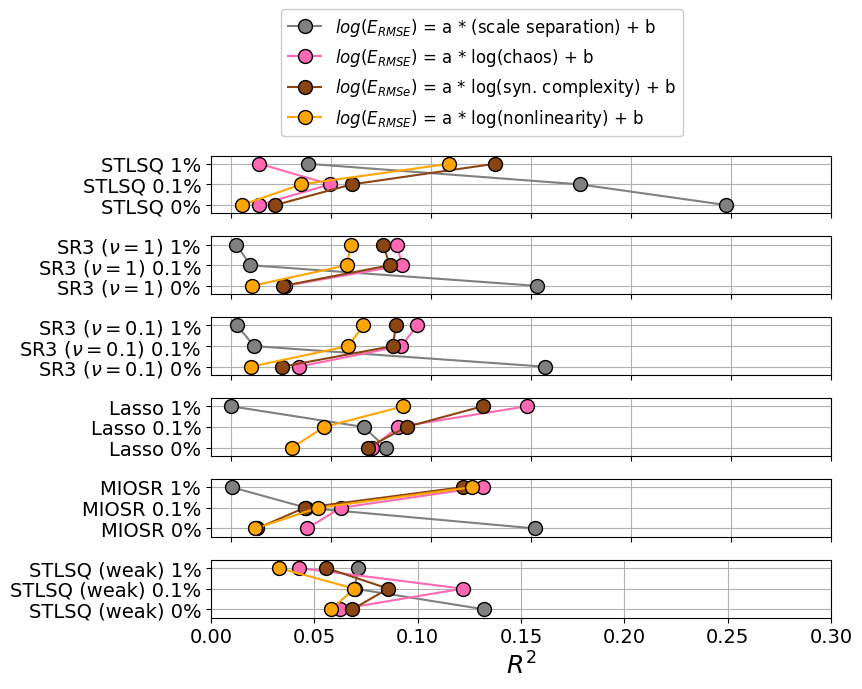

In [11]:
r_values_scale, r_values_chaos, r_values_syntax, r_values_nonlinear = compute_r2s(errors, start_index=0)
plot_dynamical_properties(r_values_scale, r_values_chaos, r_values_syntax, r_values_nonlinear)
plt.xlim(0, 0.3)
plt.savefig('best_r2_values_coef_error.pdf')
plt.show()